<h1>Clustering</h1>

Clustering is an <b>unsupervised</b> group of algorithims which cluster 'similar' data points together. In this example, we are going to cluster together groups of pokemon into their types.

The following methods will be covered using standard library functions, but there are others:<br>
k means<br>
Fuzzy C Means (FCM)<br>
Clustering Data Streams<br>
evolving clustering <br>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE #T distributed stochastic neighbour embedding
from sklearn.cluster import KMeans

df_full = pd.read_csv("../input/Pokemon.csv")

print("setup and imports complete")

setup and imports complete


In [2]:
df_full.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


<h3>Data preperation and clean up</h3>

In [3]:
#build up a type list and include a type for none
type_list = df_full['Type 1'].unique().tolist()
type_list.append('none')
#replace NaN for 'Type 2' with 'none' so it will work with the LabelEncoder
df_full['Type 2'].fillna('none',inplace=True)

#use the label encoder to convert the type names, e.g 'Grass' into integers
le = LabelEncoder()
le.fit(type_list)
LabelEncoder()

df_full['Type 1'] = le.transform(df_full['Type 1'])
df_full['Type 2']  = le.transform(df_full['Type 2'])

features = ['#','Type 1','Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation','Legendary']

In [4]:
#in Python, True is the integer 1 and False is the number 0. No further changes required.
df_full[features].sample(frac=1).head()

,#,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
265,246,15,300,50,64,50,45,50,41,2,False
427,385,16,600,100,100,100,100,100,100,3,True
592,532,5,305,75,80,55,25,35,35,5,False
257,238,11,305,45,30,15,85,65,65,2,False
605,545,0,485,60,100,89,55,69,112,5,False


<h3>K means cluster</h3>
The number of clusters must be decided by the person running the algorithm ;;there is a way to optimize this;;. The data points are placed based on euclidean distance from the centeroid mean values (a mean centroid is generated for each k number cluster). <br><br>
The example below will theoretically show us which pokemon are good special sweepers (and which are likely good physical attack sweepers).<br> <br>
<b>Definition of Sweepers</b>
A sweeper in pokemon games is a pokemon which is fast and has a good special or physical attack. Other 'archetypes' are Special defence walls, physical defence walls, stalling pokemon, and support pokemon. the last two are based more on the moves and abilities than purely stats.

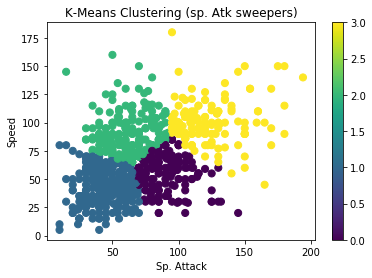

In [24]:
def GenKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = GenKmeans(df_full[['Sp. Atk','Speed']], 4)
kmeans = pd.DataFrame(clust_labels)
df_full.insert((df_full.shape[1]),'kmeans',kmeans)

#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df_full['Sp. Atk'],df_full['Speed'],c=kmeans[0],s=50)

ax.set_title('K-Means Clustering (sp. Atk sweepers)')
ax.set_xlabel('Sp. Attack')
ax.set_ylabel('Speed')

plt.colorbar(scatter)

In [20]:
#looking at the results of these two queries
#we can see the k-means has done a good job of clustering
#Special attack sweepers
df_full[(df_full['Speed'] > 120) & (df_full['Sp. Atk'] > 120)]

#probably physical attack sweepers
df_full[(df_full['Speed'] > 120) & (df_full['Sp. Atk'] < 80)]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,kmeans
23,18,PidgeotMega Pidgeot,12,7,579,83,80,80,135,80,121,1,False,3
71,65,AlakazamMega Alakazam,14,18,590,55,50,65,175,95,150,1,False,3
102,94,GengarMega Gengar,8,13,600,60,65,80,170,95,130,1,False,3
162,150,Mewtwo,14,18,680,106,110,90,154,90,130,1,True,3
163,150,MewtwoMega Mewtwo X,14,5,780,106,190,100,154,100,130,1,True,3
164,150,MewtwoMega Mewtwo Y,14,18,780,106,150,70,194,120,140,1,True,3
275,254,SceptileMega Sceptile,9,2,630,70,110,75,145,85,145,3,False,3
339,310,ManectricMega Manectric,3,18,575,70,75,80,135,80,135,3,False,3
428,386,DeoxysNormal Forme,14,18,600,50,150,50,150,50,150,3,True,3
429,386,DeoxysAttack Forme,14,18,600,50,180,20,180,20,150,3,True,3


<h3>Bonus: T distributed Stochastic Neighbour Embedding</h3>
PCA allows us to make use of all of the data, not a limited few dimensions.

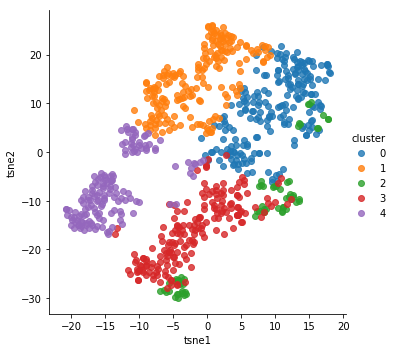

In [7]:
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = df_full[features]
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=11)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)